In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA


In [63]:
os.chdir('/Users/alexanderhepburn/Documents/MSc Data Science/1 DS Fundamentals/Assignment 2')

# Feature Engineering

Import both files as CSVs.

In [64]:
attributes = pd.read_csv('data/attributes.csv', index_col=0)
edges = pd.read_csv('data/edges_train.edgelist', names=['node1', 'node2'])

Create a Graph instance.

In [65]:
G = nx.Graph()
G.add_edges_from(edges.values)

Seems to be correct - 1500 nodes and 6600 edges.

In [66]:
print(G)

Graph with 1500 nodes and 6600 edges


Visualise as done in the lab.

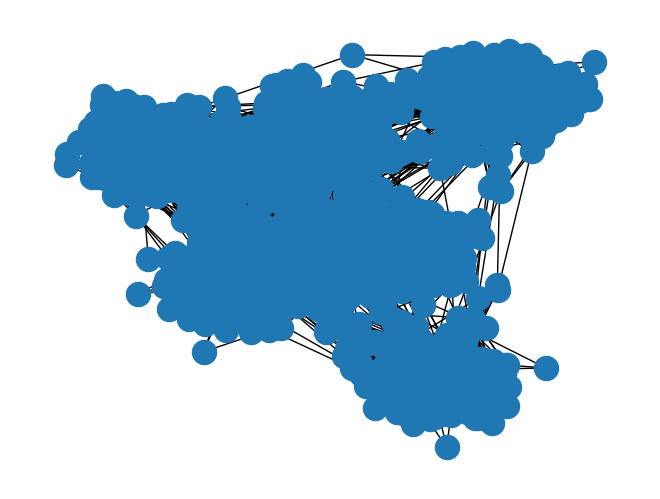

In [67]:
pos = nx.spring_layout(G)
nx.draw(G, pos=pos)

Encode 'attributes' as dummy variables.

In [68]:
attributes_one_hot = pd.get_dummies(attributes['attribute'])

This function calculates several features based on each pair of nodes within the network. 

"Common neighbours" is commented out as the feature appeared highly correlated with other features.

In [69]:
def extract_features(node1, node2, G):
    features = []
    
    # Common neighbors
    #common_neighbors = len(list(nx.common_neighbors(G, node1, node2)))
    #features.append(common_neighbors)
    
    # Jaccard Coefficient (a statistic used for gauging the similarity and diversity of sample sets.)
    jaccard_coeff = list(nx.jaccard_coefficient(G, [(node1, node2)]))[0][2]
    features.append(jaccard_coeff)
    
    # Preferential Attachment (the more connected a node is, the more likely it is to receive new links)
    pref_attach = list(nx.preferential_attachment(G, [(node1, node2)]))[0][2]
    features.append(pref_attach)
    
    # Adamic-Adar Index (the sum of the inverse logarithmic degree centrality of the neighbours shared by the two nodes)
    adamic_adar = list(nx.adamic_adar_index(G, [(node1, node2)]))[0][2]
    features.append(adamic_adar)
    
    # Attribute difference
    # Get the one-hot encoded attribute vectors for node1 and node2
    node1_attrs = attributes_one_hot.iloc[node1].values
    node2_attrs = attributes_one_hot.iloc[node2].values

    # Calculate the absolute difference in attributes between the nodes (one-hot encoded vector difference)
    attr_diff = np.sum(node1_attrs ^ node2_attrs)
    
    features.append(attr_diff)
    
    return features


Using 'extract_features' we can now construct our final X and Y sets.

In [70]:
def create_dataset(G, edges, attributes):
    X = []
    y = []
    
    # Positive samples (existing edges)
    for i, row in edges.iterrows():
        node1, node2 = row['node1'], row['node2']
        X.append(extract_features(node1, node2, G))
        y.append(1)  # Positive label
    
    # Negative samples (non-existing edges)
    non_edges = []
    while len(non_edges) < len(edges):
        node1, node2 = np.random.randint(0, len(attributes), 2)
        if not G.has_edge(node1, node2) and node1 != node2:
            X.append(extract_features(node1, node2, G))
            y.append(0)  # Negative label
            non_edges.append((node1, node2))
    
    return np.array(X), np.array(y)


In [71]:
X, y = create_dataset(G, edges, attributes)

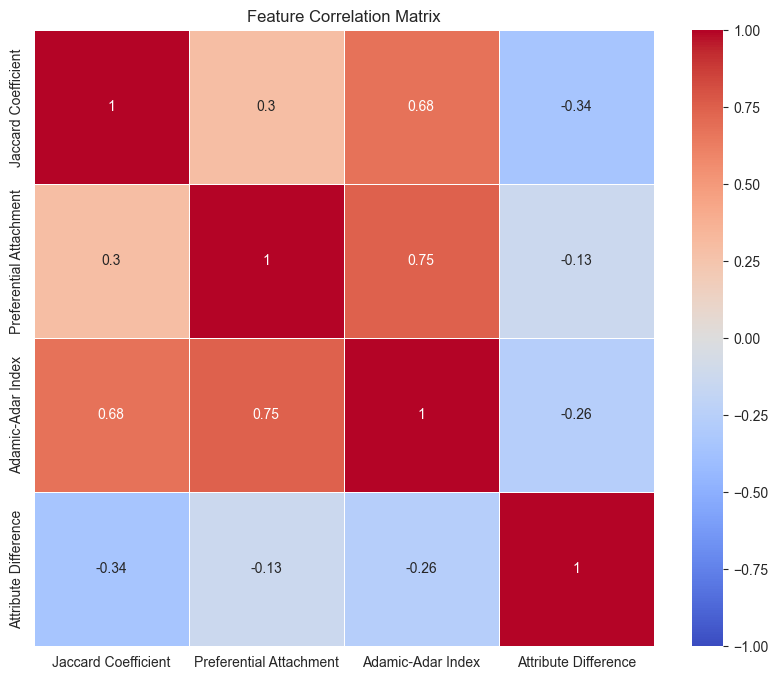

In [72]:
# Convert X_raw to a DataFrame for better visualization
feature_names = [
    #"Common Neighbours",
    "Jaccard Coefficient",
    "Preferential Attachment",
    "Adamic-Adar Index",
    #"Shortest Path Distance",
    "Attribute Difference"
]
X_df = pd.DataFrame(X, columns=feature_names)

# Step 2: Calculate the correlation matrix
corr_matrix = X_df.corr()

# Step 3: Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()

Based on the collinearity matrix I removed the 'common neighbours' feature. The above graph represents the situation after the removal. The features above are passed further into the pipeline.

PICK ONE PREPROCESSING BRANCH

### Branch 1: PCA

Principal Component Analysis

In [49]:
X, y = create_dataset(G, edges, attributes)

pca = PCA(n_components=3)  
X_pca = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)


### Branch 2: NO PCA

In [73]:
X, y = create_dataset(G, edges, attributes)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,)

# Modelling

Two models were trained - Logistic regression and Random Forest. Both demonstrate near-perfect performance.


KFold for cross-validation later.

In [74]:
kf = KFold(n_splits=10, shuffle=True, random_state= 55)

### Logistic Regression

Baseline model.

In [92]:
clf_lr = LogisticRegression(random_state=42, C=0.001, max_iter=1000)
clf_lr.fit(X_train, y_train)

y_pred = clf_lr.predict(X_test)

scores = cross_val_score(clf_lr, X_test, y_test, cv=kf)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.77 accuracy with a standard deviation of 0.02


Grid Search.

In [95]:
param_grid = {
    'C' : [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter' : [10, 100, 1000]
}

In [96]:
grid_search_lr = GridSearchCV(estimator=clf_lr, param_grid=param_grid, cv=kf, n_jobs=-1, scoring='roc_auc')
grid_search_lr.fit(X_train, y_train)
print(f"Best Parameters: {grid_search_lr.best_params_}")
print(f"Best Cross-Validation Score: {grid_search_lr.best_score_:.4f}")


/Users/alexanderhepburn/PycharmProjects/Titanic/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/alexanderhepburn/PycharmProjects/Titanic/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

Best Parameters: {'C': 100, 'max_iter': 100}
Best Cross-Validation Score: 0.8981


/Users/alexanderhepburn/PycharmProjects/Titanic/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/alexanderhepburn/PycharmProjects/Titanic/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

In [97]:
# Retrain the model with the best parameters
best_clf_lr = grid_search.best_estimator_
best_clf_lr.fit(X_train, y_train)

# Evaluate on the held-out test set again
y_pred_best = best_clf_lr.predict(X_test)
print("Accuracy with Best Parameters:", accuracy_score(y_test, y_pred_best))
print("Classification Report with Best Parameters:\n", classification_report(y_test, y_pred_best))

Accuracy with Best Parameters: 0.8446969696969697
Classification Report with Best Parameters:
               precision    recall  f1-score   support

           0       0.84      0.85      0.85      1329
           1       0.85      0.84      0.84      1311

    accuracy                           0.84      2640
   macro avg       0.84      0.84      0.84      2640
weighted avg       0.84      0.84      0.84      2640


CM Logreg

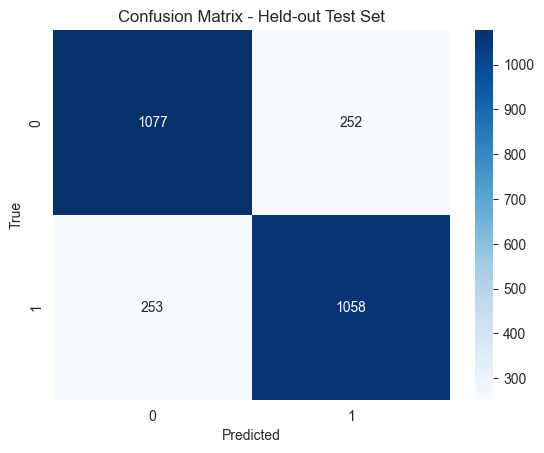

In [98]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Held-out Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Random Forest

Baseline model.

In [99]:
clf_rf = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=3)
clf_rf.fit(X_train, y_train)
y_pred = clf_rf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8443181818181819
              precision    recall  f1-score   support

           0       0.83      0.86      0.85      1329
           1       0.86      0.82      0.84      1311

    accuracy                           0.84      2640
   macro avg       0.84      0.84      0.84      2640
weighted avg       0.84      0.84      0.84      2640


Grid Search.

In [100]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [101]:
# Perform GridSearchCV
grid_search_rf = GridSearchCV(estimator=clf_rf, param_grid=param_grid, cv=kf, n_jobs=-1, scoring='roc_auc')
grid_search_rf.fit(X_train, y_train)

# Output the best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best Cross-Validation Score: 0.9023


In [102]:
# Retrain the model with the best parameters
best_clf_rf = grid_search_rf.best_estimator_
best_clf_rf.fit(X_train, y_train)

# Evaluate on the held-out test set again
y_pred_best = best_clf_rf.predict(X_test)
print("Accuracy with Best Parameters:", accuracy_score(y_test, y_pred_best))
print("Classification Report with Best Parameters:\n", classification_report(y_test, y_pred_best))

Accuracy with Best Parameters: 0.8446969696969697
Classification Report with Best Parameters:
               precision    recall  f1-score   support

           0       0.84      0.85      0.85      1329
           1       0.85      0.84      0.84      1311

    accuracy                           0.84      2640
   macro avg       0.84      0.84      0.84      2640
weighted avg       0.84      0.84      0.84      2640


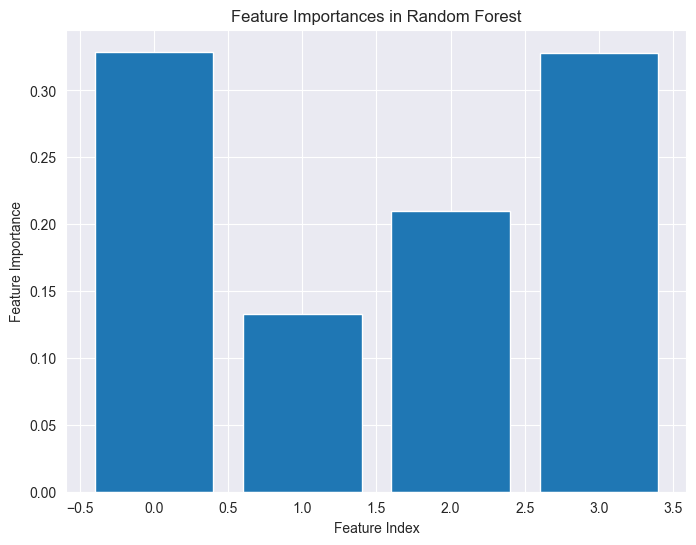

In [103]:
importances = best_clf_rf.feature_importances_
# Plot feature importance
plt.figure(figsize=(8, 6))
plt.bar(range(len(importances)), importances)
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.title('Feature Importances in Random Forest')
plt.show()

CM Random forest

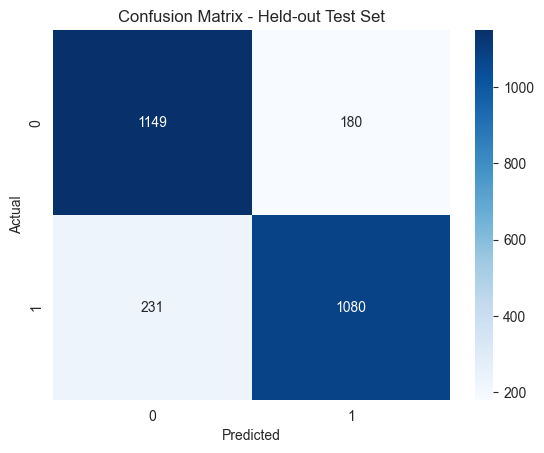

In [104]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Held-out Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

ROC CURVE

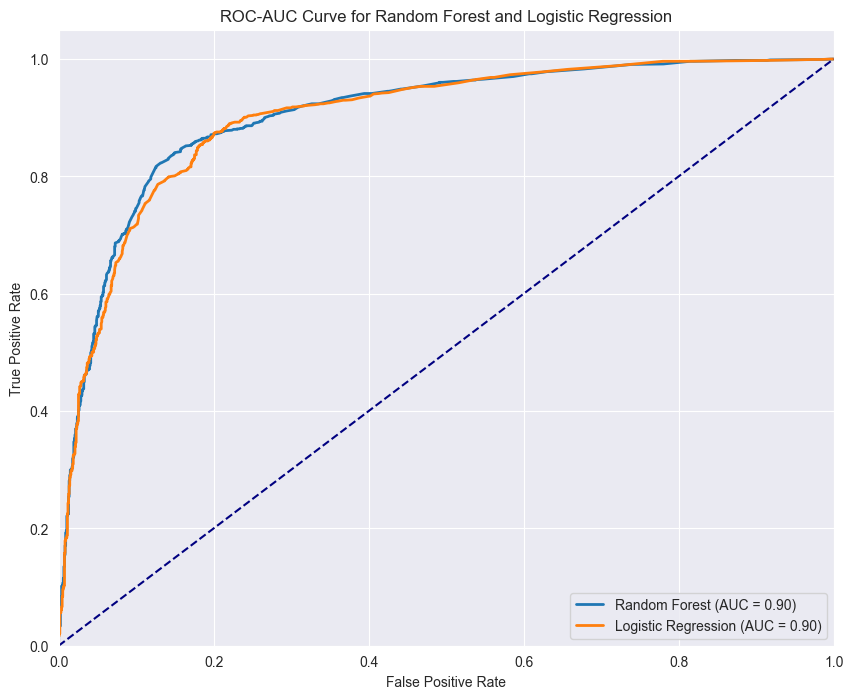

In [106]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

best_rf = grid_search_rf.best_estimator_
best_logreg = grid_search_lr.best_estimator_


y_pred_proba_rf = best_rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)


y_pred_proba_logreg = best_logreg.predict_proba(X_test)[:, 1]
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_pred_proba_logreg)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)


plt.figure(figsize=(10, 8))

plt.plot(fpr_rf, tpr_rf, lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_logreg, tpr_logreg, lw=2, label=f'Logistic Regression (AUC = {roc_auc_logreg:.2f})')


plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve for Random Forest and Logistic Regression')
plt.legend(loc="lower right")


plt.show()
